In [114]:
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings
import datetime

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

# helper

In [115]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
    
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# train and test

In [116]:
# preprocessing train & test
def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv('../input/train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('../input/test.csv', index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1

    # set target as nan
    test_df['target'] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.date(2018, 4, 30) - df['first_active_month'].dt.date).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum'] / 3
    
    features = ['feature_1', 'feature_2', 'feature_3']
    t = df[features]
    df['feature_max'] = t.max(axis=1)
    df['feature_min'] = t.min(axis=1)
    df['feature_var'] = t.std(axis=1)

    return df

# historical_transactions

In [175]:
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('../input/historical_transactions.csv', nrows=num_rows)
    hist_df = hist_df.query('purchase_amount < 6000000')
    hist_df['purchase_amount'] = np.log1p(hist_df['purchase_amount'] - hist_df['purchase_amount'].min())
    
    # fillna
    hist_df['category_2'].fillna(1.0,inplace=True)
    hist_df['category_3'].fillna('A',inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    hist_df['installments'].replace(-1, np.nan,inplace=True)
    hist_df['installments'].replace(999, np.nan,inplace=True)

    # trim
#     hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']
    
    RANGE = 30
#     hist_df['Mothers_Day_2017'] = (pd.to_datetime('2017-06-04') - hist_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     hist_df['Valentine_Day_2017'] = (pd.to_datetime('2017-06-12') - hist_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     hist_df['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - hist_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     hist_df['Children_day_2017'] = (pd.to_datetime('2017-10-12') - hist_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     hist_df['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     hist_df['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') -hist_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     hist_df['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.date(2018, 4, 30) - hist_df['purchase_date'].dt.date).dt.days) // 30
    hist_df['month_diff'] += hist_df['month_lag']

    hist_df['duration'] = hist_df['purchase_amount'] * hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount'] / hist_df['month_diff']

    hist_df = reduce_mem_usage(hist_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['installments'] = ['max','mean', 'var','skew'] # 'sum'
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max', 'min', 'mean', 'var', 'skew'] # 'max', 'min'
    aggs['month_diff'] = ['max', 'min', 'mean', 'var', 'skew'] # 'max', 'min'
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] # overwrite
    aggs['weekday'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['nunique'] # 'mean'
    aggs['category_3'] = ['nunique'] # 'mean'
    aggs['card_id'] = ['size', 'count']
    aggs['price'] = ['sum', 'mean', 'max', 'min', 'var']
#     aggs['Christmas_Day_2017'] = ['sum', 'mean']
#     aggs['Mothers_Day_2017'] = ['sum', 'mean']
#     aggs['fathers_day_2017'] = ['sum', 'mean']
#     aggs['Children_day_2017'] = ['sum', 'mean']
#     aggs['Valentine_Day_2017'] = ['sum', 'mean']
#     aggs['Black_Friday_2017'] = ['sum', 'mean']
#     aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration'] = ['mean', 'min', 'max', 'var', 'skew']
    aggs['amount_month_ratio'] = ['mean', 'min', 'max', 'var', 'skew']

    for col in ['category_2','category_3']:
        hist_df[col + '_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col + '_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col + '_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col + '_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col + '_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_'+ c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max'] - hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff'] / hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.date(2018, 4, 30)-hist_df['hist_purchase_date_max'].dt.date).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.date(2018, 4, 30)-hist_df['hist_purchase_date_min'].dt.date).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df

# new_merchant_transactions

In [185]:
def new_merchant_transactions(num_rows=None):
    new_merchant_df = pd.read_csv('../input/new_merchant_transactions.csv', nrows=num_rows)
    new_merchant_df['purchase_amount'] = np.log1p(new_merchant_df['purchase_amount'] - new_merchant_df['purchase_amount'].min())
    
    
    new_merchant_df['category_2'].fillna(1.0,inplace=True)
    new_merchant_df['category_3'].fillna('A',inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
    new_merchant_df['installments'].replace(999, np.nan,inplace=True)

#     new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A': 0, 'B': 1, 'C': 2}).astype(int)

    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    RANGE = 30
#     new_merchant_df['Mothers_Day_2017'] = (pd.to_datetime('2017-06-04') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     new_merchant_df['Valentine_Day_2017'] = (pd.to_datetime('2017-06-12') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     new_merchant_df['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: 1 if x > -RANGE and x < RANGE else 0)
#     new_merchant_df['Children_day_2017'] = (pd.to_datetime('2017-10-12') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > -RANGE and x < RANGE else 0)
#     new_merchant_df['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > -RANGE and x < RANGE else 0)
#     new_merchant_df['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > -RANGE and x < RANGE else 0)
#     new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > -30 and x < 30 else 0)

    new_merchant_df['month_diff'] = ((datetime.date(2018, 4, 30) - new_merchant_df['purchase_date'].dt.date).dt.days) // 30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    new_merchant_df['duration'] = new_merchant_df['purchase_amount'] * new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount'] / new_merchant_df['month_diff']

    new_merchant_df = reduce_mem_usage(new_merchant_df)

    col_unique = ['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['installments'] = ['max', 'mean', 'var', 'skew'] # 'sum'
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_lag'] = ['mean', 'var', 'skew'] # 'max', 'min'
    aggs['month_diff'] = ['mean', 'var', 'skew'] # 'max', 'min'
    aggs['month'] = ['mean'] # 'max', 'min'
    aggs['weekday'] = ['mean'] # 'max', 'min'
    aggs['weekend'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['nunique'] # 'mean'
    aggs['category_3'] = ['nunique'] # 'mean'
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['mean', 'max', 'min', 'var']
#     aggs['Christmas_Day_2017'] = ['sum', 'mean']
#     aggs['Mothers_Day_2017'] = ['sum', 'mean']
#     aggs['fathers_day_2017'] = ['sum', 'mean']
#     aggs['Children_day_2017'] = ['sum', 'mean']
#     aggs['Valentine_Day_2017'] = ['sum', 'mean']
#     aggs['Black_Friday_2017'] = ['sum', 'mean']
#     aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration'] = ['mean', 'min', 'max', 'var', 'skew']
    aggs['amount_month_ratio'] = ['mean', 'min', 'max', 'var', 'skew']

    for col in ['category_2','category_3']:
        new_merchant_df[col + '_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col + '_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col + '_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col + '_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col + '_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_' + c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max'] - new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff'] / new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (datetime.date(2018, 4, 30) - new_merchant_df['new_purchase_date_max'].dt.date).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (datetime.date(2018, 4, 30) - new_merchant_df['new_purchase_date_min'].dt.date).dt.days

    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df

# additional_features

In [186]:
# additional features
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
#     df['month_lag_max'] = df['new_month_lag_max'] + df['hist_month_lag_max']
#     df['month_lag_min'] = df['new_month_lag_min'] + df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
#     df['installments_total'] = df['new_installments_sum'] + df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
#     df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
#     df['installments_ratio'] = df['new_installments_sum'] / df['hist_installments_sum']
#     df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
#     df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
    df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
    df['amount_month_ratio_mean'] = df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min'] = df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max'] = df['new_amount_month_ratio_max' ]+ df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df

In [187]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=['train', 'test'],
            num_boost_round=10000,
            early_stopping_rounds= 200,
            verbose_eval=100
        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:,'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

In [188]:
num_rows = None

In [189]:
with timer("train & test"):
    df = train_test(num_rows)

Train samples: 201917, test samples: 123623
train & test - done in 3s


In [190]:
with timer("historical transactions"):
    historical_transactions_df = historical_transactions(num_rows)

Memory usage after optimization is: 1860.17 MB
Decreased by 66.5%
Memory usage after optimization is: 52.16 MB
Decreased by 55.1%
historical transactions - done in 961s


In [191]:
df = pd.merge(df, historical_transactions_df, on='card_id', how='outer')

In [192]:
with timer("new merchants"):
    new_merchant_transactions_df = new_merchant_transactions(num_rows)

Memory usage after optimization is: 110.45 MB
Decreased by 69.3%
Memory usage after optimization is: 39.00 MB
Decreased by 59.0%
new merchants - done in 353s


In [193]:
df = pd.merge(df, new_merchant_transactions_df, on='card_id', how='outer')

In [194]:
with timer("additional features"):
    df = additional_features(df)

additional features - done in 0s


In [195]:
with timer("split train & test"):
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    del df
    gc.collect()

split train & test - done in 1s


Starting LightGBM. Train shape: (201917, 173), test shape: (123623, 173)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65763	test's rmse: 3.7388
[200]	train's rmse: 3.5807	test's rmse: 3.70114
[300]	train's rmse: 3.53683	test's rmse: 3.68752
[400]	train's rmse: 3.50424	test's rmse: 3.68222
[500]	train's rmse: 3.47851	test's rmse: 3.68015
[600]	train's rmse: 3.45699	test's rmse: 3.67808
[700]	train's rmse: 3.43934	test's rmse: 3.67693
[800]	train's rmse: 3.42181	test's rmse: 3.67671
[900]	train's rmse: 3.40502	test's rmse: 3.67641
[1000]	train's rmse: 3.3891	test's rmse: 3.67713
[1100]	train's rmse: 3.37469	test's rmse: 3.67729
Early stopping, best iteration is:
[904]	train's rmse: 3.40419	test's rmse: 3.67629
Fold  1 RMSE : 3.676294
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65319	test's rmse: 3.78034
[200]	train's rmse: 3.57629	test's rmse: 3.74241
[300]	train's rmse: 3.53269	test's rmse: 3.7311
[400]	tra

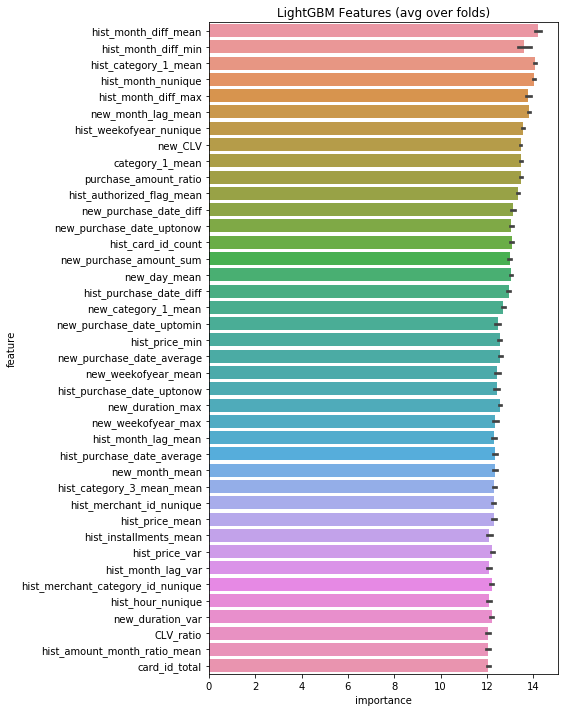

In [196]:
submission_file_name = "submission.csv"
with timer("Run LightGBM with kfold"):
    kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False, debug=False)

Starting LightGBM. Train shape: (201917, 199), test shape: (123623, 199)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66524	test's rmse: 3.74403
[200]	train's rmse: 3.59091	test's rmse: 3.70933
[300]	train's rmse: 3.54611	test's rmse: 3.69965
[400]	train's rmse: 3.51438	test's rmse: 3.69686
[500]	train's rmse: 3.48921	test's rmse: 3.69488
[600]	train's rmse: 3.46812	test's rmse: 3.69443
[700]	train's rmse: 3.45175	test's rmse: 3.69388
[800]	train's rmse: 3.43661	test's rmse: 3.69372
[900]	train's rmse: 3.42298	test's rmse: 3.69407
Early stopping, best iteration is:
[763]	train's rmse: 3.44227	test's rmse: 3.69339
Fold  1 RMSE : 3.693390
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65905	test's rmse: 3.78957
[200]	train's rmse: 3.58518	test's rmse: 3.75801
[300]	train's rmse: 3.54143	test's rmse: 3.74922
[400]	train's rmse: 3.51114	test's rmse: 3.74585
[500]	train's rmse: 3.48597	test's rmse: 3.74499
[600]	t

[1700]	train's rmse: 3.31361	test's rmse: 3.67162
[1800]	train's rmse: 3.30266	test's rmse: 3.67119
[1900]	train's rmse: 3.2899	test's rmse: 3.67103
[2000]	train's rmse: 3.2786	test's rmse: 3.67124
[2100]	train's rmse: 3.26561	test's rmse: 3.6716
Early stopping, best iteration is:
[1909]	train's rmse: 3.28906	test's rmse: 3.6709
Fold 11 RMSE : 3.670904
Run LightGBM with kfold - done in 841s


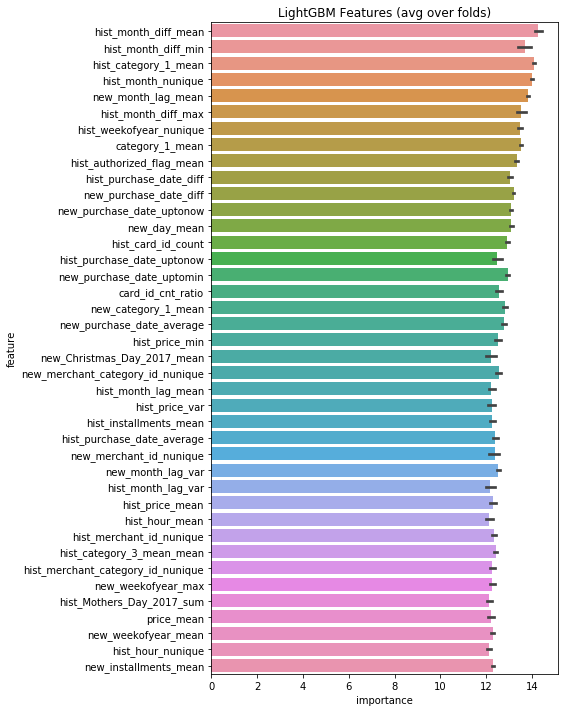

In [174]:
submission_file_name = "submission.csv"
with timer("Run LightGBM with kfold"):
    kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False, debug=False)